# Network 2 Random Neural Networks
Random Neural Networks - with neural units but topology defined randomly.

## Imports

In [1]:
import matplotlib.pyplot as plt
import scipy.io as sio
from scipy.integrate import odeint
import numpy as np
from tqdm import tqdm
import math

## Creating the network

In [2]:
def connection_matrix(n,mean,variance):
    ''' 
    The elements of the n x n connection matrix J are drawn independently from a Gaussian distribution
    J_ii = 0
    '''
    J = np.random.normal(loc=mean, scale=np.sqrt(variance), size=(n, n))
    np.fill_diagonal(J, 0)
    return J

In [3]:
N = 400 # number of nodes

# connection matrix
J = connection_matrix(N,0,1/N)
J.shape

# parameters for the dynamics
s = .4
g = .4

## Running the Dynamics

$$\frac{d{x_i}}{dt} = - {x_i} + s \tanh({x_i}) + g \sum_{j\ne i}^{N}J_{ij}\tanh({x_j})$$ 


In [4]:
def neural_network_ODE(values, t, J, s=2.5, g=0.5):
    ''' 
    Neural units' dynamics
    -----------
    Return rate values
    '''
    
    dvalues_dt = -values + s*np.tanh(values) + g*np.dot(J,np.tanh(values))

    return dvalues_dt

In [5]:
n_nodes = J.shape[0]
initial_values = np.ones(n_nodes) * 2
print(initial_values.shape)
t = np.arange(0, 100, 0.1)

# Solving ODEs
values = odeint(neural_network_ODE, initial_values, t, args=(J,s,g))

print(values.shape)


(400,)
(1000, 400)


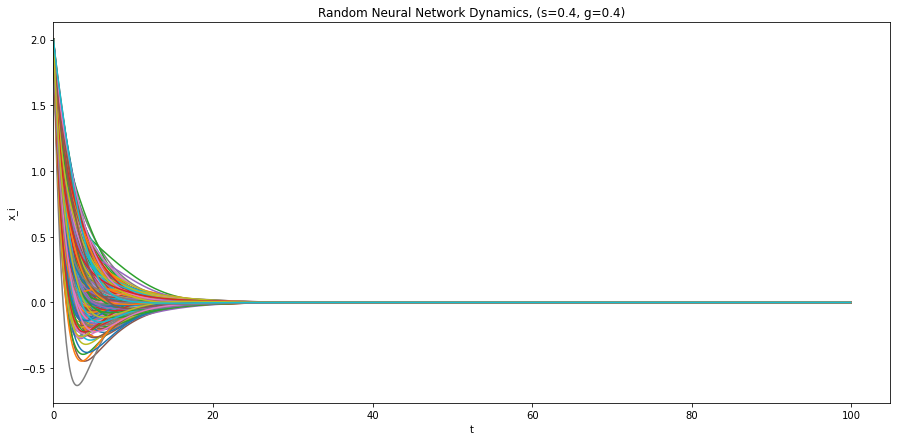

In [6]:
plt.figure(figsize=(15,7))

plt.plot(t, values)
plt.xlim(xmin=0)
plt.xlabel('t')
plt.ylabel('x_i')

plt.title(f'Random Neural Network Dynamics, (s={s}, g={g})')

plt.show()

## Removing nodes

In [7]:
def remove_nodes(A, n_rem):
    ''' 
    Randomly removes 'n_rem' nodes from a network.
    -------------------
    Returns the resultant matrix
    '''
    if A.shape[0] == 0:
        return A
    
    rem_idx = np.random.choice(np.arange(A.shape[0]), size=n_rem)

    A_rem_row = np.delete(A, rem_idx, 0)
    A_curr = np.delete(A_rem_row, rem_idx, 1)

    return A_curr
    
def get_activity_remnode(A_curr,h=0.1,tf=200, s=0.5, g=2.5):
    ''' 
    Returns the average activity (positive and negative, separately) of a network at time 'tf'
    '''
    t = np.arange(0, tf, h)
    initial_values = np.ones(A_curr.shape[0]) * 2

    values = odeint(neural_network_ODE, initial_values, t, args=(A_curr,s,g))
    
    # Filter for positive values
    positive_values = values[-1][values[-1] >= 0]

    # Filter for negative values
    negative_values = values[-1][values[-1] < 0]

    return np.mean(positive_values), np.mean(negative_values)


In [8]:
f_rem = 0.02    # fraction of nodes to be removed
nruns = 10      # number of simulations

h = 0.1
tf = 100


In [9]:
activities_nruns = []   # avergage activities
activities_pos_nruns = []   # avergage positive activities
activities_neg_nruns = []   # avergage activities
F_N = []    # fraction of nodes removed
N_rem = []  # number of nodes removed
max_iter = J.shape[0]

cuttoff = 0.996
for i in tqdm(range(nruns)):
    f_n = 0
    activities_pos = []
    activities_neg = []
    J_ret = J
    remove = False
    itr = 0
    
    while (i==0 and f_n < cuttoff) or (i!=0 and itr<max_iter):
        if(i==0):
            # finding number of nodes removed
            n_rem = math.ceil(J_ret.shape[0]*f_rem) if remove else 0
            N_rem.append(n_rem)
        
        # removing nodes        
        J_ret = remove_nodes(J_ret, N_rem[itr])
        
        if (J_ret.shape[0]!=0):
            # calculating activities
            x_avg_pos, x_avg_neg= get_activity_remnode(J_ret, h, tf, s, g)
            activities_pos.append(x_avg_pos)  # Store positive activities
            activities_neg.append(x_avg_neg)  # Store negative activities
                
        else:
            activities_pos.append(0)
            activities_neg.append(0)

        remove = True
        itr+= 1

        if(i==0):
            f_n+= N_rem[-1]/ J.shape[0]
            F_N.append(f_n)
            max_iter = itr
    
    # activities_nruns.append(activities)
    activities_pos_nruns.append(activities_pos)
    activities_neg_nruns.append(activities_neg)
    
    

 60%|██████    | 6/10 [00:28<00:18,  4.66s/it]c:\Users\drshw\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\drshw\anaconda3\lib\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
100%|██████████| 10/10 [00:46<00:00,  4.64s/it]


In [10]:
print(N-np.sum(N_rem))

activities_pos_nruns = np.array(activities_pos_nruns)
activities_neg_nruns = np.array(activities_neg_nruns)

print(activities_pos_nruns.shape)
print(activities_neg_nruns.shape)
print(len(F_N))

random_run = np.random.choice(range(nruns),1)[0]
print(random_run)

1
(10, 131)
(10, 131)
131
8


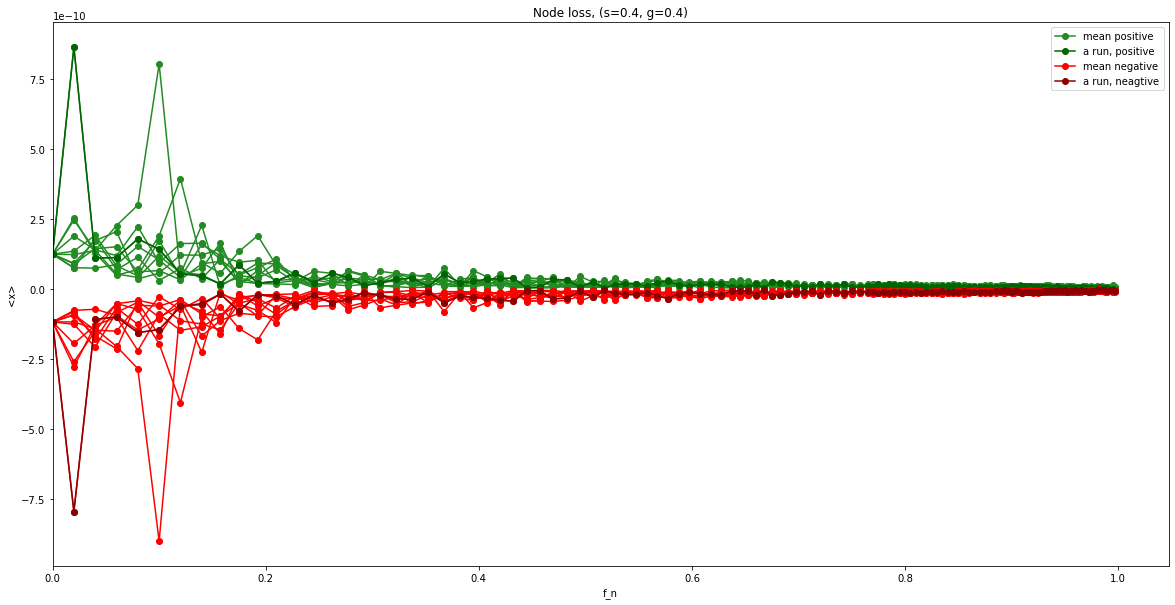

In [11]:
plt.figure(figsize=(20,10))

POS = 'forestgreen'
NEG = 'red'

plt.plot(F_N,activities_pos_nruns[:1].T, 'o-', color=POS, label = 'mean positive')
plt.plot(F_N,activities_pos_nruns[1:].T, 'o-', color=POS)
plt.plot(F_N,activities_pos_nruns[random_run].T, 'o-', color='darkgreen', label='a run, positive')

plt.plot(F_N,activities_neg_nruns[:1].T, 'o-', color=NEG, label = 'mean negative')
plt.plot(F_N,activities_neg_nruns[1:].T, 'o-', color=NEG)
plt.plot(F_N,activities_neg_nruns[random_run].T, 'o-', color='darkred', label='a run, neagtive')

plt.xlim(xmin=0)
plt.xlabel(f'f_n')
plt.ylabel(f'<x>')
plt.title(f'Node loss, (s={s}, g={g})')
plt.legend()

plt.show()